Imports and Data

In [ ]:
!pip install mplfinance
import mplfinance as mpl
import numpy as np
import pandas as pd
import tensorflow as tf
spy_thirty_min = pd.DataFrame(np.array(pd.read_csv('/content/drive/MyDrive/SPY_qjrt28/SPY_30min.txt', header=None)), columns=['Time', 'Open', 'High', 'Low', 'Close', 'Volume'])
spy_hourly = pd.DataFrame(np.array(pd.read_csv('/content/drive/MyDrive/SPY_qjrt28/SPY_1hour.txt', header=None)), columns=['Time', 'Open', 'High', 'Low', 'Close', 'Volume'])
five_min_data = pd.DataFrame(np.array(pd.read_csv('/content/drive/MyDrive/SPY_qjrt28/SPY_5min.txt', header=None)), columns=['Time', 'Open', 'High', 'Low', 'Close', 'Volume'])


Supply and Demand Helper Funcs

In [ ]:
# Helper Functions

def get_change(candle):
  diff = candle[4]/candle[1]
  if candle[4] > candle[1]:
    change = diff - 1
  else:
    change = 1 - diff

  return change

def no_long_wicks(candle, thresh_pct):
  thresh = thresh_pct*get_change(candle)
  candle_open, candle_high, candle_low, candle_close = candle[1], candle[2], candle[3], candle[4]
  if candle_close > candle_open:
    if candle_high/candle_close - 1 < thresh and candle_open/candle_low - 1 < thresh:
      return True
  else:
    if candle_high/candle_open - 1 < thresh and candle_close/candle_low - 1 < thresh:
      return True
  return False


def is_basing(candle, next_candle_change, thresh_pct):
  """ Criterion for basing candle
  1. Must be less than half of the next candle
  """
  if get_change(candle) > 0.5*next_candle_change:
    return False
  
  """ 
  2. Must have small wicks, meaning if it is a green candle, high is close to 
  close and low is close to open, and if it is red, then vice versa.

  "Closeness" is dependent on the candle's change. Define closeness threshold as within thresh_pct of the candle's change 
  """
  return no_long_wicks(candle, thresh_pct)

def is_zone(candle, next_candle, large_change, thresh_pct, supply, demand):

  # Criterion for Supply/Demand Zone:
  # 1. Next candle must have large % change between open and close
  if get_change(next_candle) >= large_change:
    # 2. Next candle must not have long wicks
    if no_long_wicks(next_candle, thresh_pct):
      # 3. Must have basing candle
      if is_basing(candle, get_change(next_candle), thresh_pct):
        if next_candle[4] > next_candle[1] and demand:
          return True
        elif next_candle[4] < next_candle[1] and supply:
          return True
  return False

def get_zones(data, large_change, thresh_pct, supply, demand):
  zones = []
  for i in range(len(data.values)):
    if i + 1 < len(data.values):
      candle = data.values[i]
      next_candle = data.values[i + 1]
      if is_zone(candle, next_candle, large_change, thresh_pct, supply, demand):
          zones.append([candle, next_candle])
  return np.array(zones)

Get Zones for Model

In [ ]:
zones = get_zones(spy_hourly, 0.0018, 0.8, False, True)
print(zones.shape)

(812, 2, 6)


Function for Compiling Model Data from Zone Data

Model Input: Image of TPO profile representing 100 five-minute intervals of price data before price retests supply/demand zone

Output: 0 (After 50 mins of retesting supply/demand zone, price does not increase) or 1 (Price does increase after 50 mins)

In [ ]:
def get_model_data_cnn(five_min_data, thirty_min_data, zones):
  outcome_context = []
  outcome = []

  five_min_times = five_min_data.values[:, 0]
  thirty_min_times = thirty_min_data.values[:, 0]

  for zone in zones:
    try:
      # Zone start time
      zone_start = zone[0][0]
      
      # Find index of zone start time in five min data
      five_min_idx = np.where(five_min_times==zone_start)[0]
      thirty_min_idx = np.where(thirty_min_times==zone_start)[0]

      if len(five_min_idx) == 1 and len(thirty_min_idx) == 1:

        # Collect 100 candles of outcome context
        # Scan forward until retest of zone
        search = five_min_idx + 24 

        # Supply or Demand
        if zone[1][4] > zone[1][1]:
          # Zone price level
          if zone[0][4] > zone[0][1]:
            price_level = zone[0][4]
          else:
            price_level = zone[0][1]
          while np.all(price_level <= five_min_data.values[search][:, [1, 2, 3, 4]]):
            search += 1

        else:
          if zone[0][4] > zone[0][1]:
            price_level = zone[0][1]
          else:
            price_level = zone[0][4]
          while np.all(price_level >= five_min_data.values[search][:, [1, 2, 3, 4]]):
            search += 1

        search += 1
        start = search[0] - 100
        end = search[0]
        outcome_context.append(five_min_data.values[start:end])

        start = search[0]
        end = search[0] + 10
        if zone[1][4] > zone[1][1]:
          if five_min_data.values[end][4] > five_min_data.values[search[0]][4]:
            result = 1
          else:
            result = 0
        else:
          if zone[0][4] > zone[0][1]:
            price_level = zone[0][1]
          else:
            price_level = zone[0][4]
          if five_min_data.values[end][4] < five_min_data.values[search[0]][4]:
            result = 1
          else:
            result = 0
        outcome.append(result)
      
    except:
      pass

  outcome_context = np.array(outcome_context)
  outcome = np.array(outcome)

  return outcome_context, outcome


In [ ]:
outcome_context, outcome = get_model_data_cnn(five_min_data, spy_thirty_min, zones)

In [ ]:
print(outcome_context.shape, outcome.shape)

(714, 100, 6) (714,)


Helper Functions for Creating Images of Time-Price-Opportunity Profiles

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import patches
from PIL import Image
from keras.preprocessing.image import img_to_array
import cv2

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def float2color(percentage):
    color_part_dec = int(255 * percentage)
    color_part_hex = str(hex(color_part_dec))[2:]
    return "#" + color_part_hex + color_part_hex + color_part_hex


def find_longest_row(tpo):
  longest = 0
  for level in tpo:
    if len(tpo[level]) > longest:
      longest = len(tpo[level])
  return longest


def make_multi_tpo(series, num_tpo):
  # Dict of price levels for each group
  tpos = {}
  for i in range(num_tpo):
    minprice = np.round(min(series[:, 3]), 2)
    maxprice = np.round(max(series[:, 4]), 2)
    levels = {}
    p = minprice
    increment = np.round((maxprice - minprice)/20, 2)
    while p <= maxprice:
      levels[p] = []
      p += increment
    tpos[i] = levels

  # Make TPO dict
  start = 0
  end = int(len(series)/num_tpo)
  i = 230
  for j in range(num_tpo):
    levels = tpos[j]
    prices = np.array(list(levels.keys()))
    for row in series[start:end]:
      price = np.round(row[4], 2)
      closest = find_nearest(prices, price)
      if levels[closest]:
        levels[closest].append(i)
      else:
        levels[closest] = [i]
    i -= 50
    start += int(len(series)/num_tpo)
    end += int(len(series)/num_tpo)

  # Blank image
  fig = plt.figure(figsize=(20,5))
  plt.savefig('greyscale.png')
  plt.close()

  # Load image
  im = Image.open('greyscale.png')
  fig, ax = plt.subplots()
  plt.axis('off')
  ax.imshow(im)
  shift = 0

  # Draw Squares
  for i in tpos:
    levels = tpos[i]
    ycoord = 0
    for level in levels:
      xcoord = shift
      for val in levels[level]:
        color = float2color(val/255)
        rect = patches.Rectangle((xcoord, ycoord), 25, 25, linewidth=0, edgecolor=color, facecolor=color)
        ax.add_patch(rect)
        xcoord += 25
      ycoord+=25
    shift += 25*find_longest_row(levels)

  plt.savefig('greyscale')
  plt.close()
  img = Image.open('greyscale.png')

  # Crop
  left = 80
  top = 181
  right = 500
  bottom = 304
  img = img.crop((left, top, right, bottom))  
  img_array = img_to_array(img)
  plt.close()

  return img_array

Convert Time-Series Data to TPO Profiles

In [ ]:
inputs = []
for i in range(len(outcome_context)):
  inputs.append(make_multi_tpo(outcome_context[i], 4))
  np.save('drive/MyDrive/Project/img_arrays', np.array(inputs))
  np.save('drive/MyDrive/Project/outcomes', np.array(outcome[:i+1]))
  print(len(inputs))

In [ ]:
inputs = np.load('drive/MyDrive/Project/img_arrays.npy')
outcome = np.load('drive/MyDrive/Project/outcomes.npy')

In [ ]:
print(inputs.shape, outcome.shape)

(714, 123, 420, 4) (714,)


Sample of TPO Profile

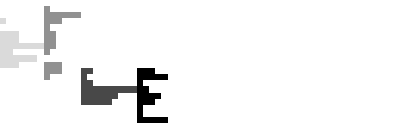

In [ ]:
from keras.preprocessing.image import array_to_img
array_to_img(inputs[np.random.randint(len(inputs))])

CNN:

In [ ]:
from keras.layers import Conv2D, Dense, Input, MaxPool2D, Flatten, Dropout, Reshape
from keras.constraints import min_max_norm, unit_norm
from keras import Model


def cnn():
  x_input = Input(shape=(123, 420, 4)) 
  x = Conv2D(filters=3, kernel_size=(3,3), padding='valid', activation='relu', kernel_initializer='he_normal')(x_input)
  x = Dropout(0.2)(x)
  x = MaxPool2D()(x)
  x = Conv2D(filters=3, kernel_size=(3,3), padding='valid', activation='relu', kernel_initializer='he_normal')(x)
  x = Dropout(0.2)(x)
  x = MaxPool2D()(x)
  x = Conv2D(filters=3, kernel_size=(3,3), padding='valid', activation='relu', kernel_initializer='he_normal')(x)
  x = Dropout(0.2)(x)
  x = MaxPool2D()(x)
  x = Conv2D(filters=3, kernel_size=(3,3), padding='valid', activation='relu', kernel_initializer='he_normal')(x)
  x = Dropout(0.2)(x)
  x = MaxPool2D()(x)
  x = Conv2D(filters=1, kernel_size=(3,3), padding='valid', activation='relu', kernel_initializer='he_normal')(x)
  x = Flatten()(x)

  x = Dense(32, activation='relu')(x)
  x = Dense(16, activation='relu')(x)
  out = Dense(1, activation='sigmoid')(x)

  model = Model(inputs= x_input, outputs = out, name='CNN')
  return model

cnn = cnn()
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 123, 420, 4)]     0         
                                                                 
 conv2d_15 (Conv2D)          (None, 121, 418, 3)       111       
                                                                 
 dropout_12 (Dropout)        (None, 121, 418, 3)       0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 60, 209, 3)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 58, 207, 3)        84        
                                                                 
 dropout_13 (Dropout)        (None, 58, 207, 3)        0         
                                                               

In [ ]:
inputs = np.array(inputs)

In [ ]:
split = int(len(inputs)*0.7)
input_train, input_test, output_train, output_test = inputs[:split], inputs[split:], outcome[:split], outcome[split:]

In [ ]:
print(np.unique(output_test, return_counts=True))

(array([0, 1]), array([107, 108]))


In [ ]:
cnn.fit(input_train, output_train, validation_data=(input_test, output_test), batch_size=32, epochs=20)

Epoch 1/20
16/16 [==============================] - 8s 517ms/step - loss: 0.6842 - accuracy: 0.5271 - val_loss: 0.6885 - val_accuracy: 0.5674
Epoch 2/20
16/16 [==============================] - 11s 695ms/step - loss: 0.6816 - accuracy: 0.5691 - val_loss: 0.6869 - val_accuracy: 0.5767
Epoch 3/20
16/16 [==============================] - 13s 784ms/step - loss: 0.6874 - accuracy: 0.5511 - val_loss: 0.6871 - val_accuracy: 0.5628
Epoch 4/20
16/16 [==============================] - 8s 515ms/step - loss: 0.6830 - accuracy: 0.5431 - val_loss: 0.6867 - val_accuracy: 0.5674
Epoch 5/20
16/16 [==============================] - 8s 515ms/step - loss: 0.6866 - accuracy: 0.5411 - val_loss: 0.6855 - val_accuracy: 0.5814
Epoch 6/20
16/16 [==============================] - 8s 516ms/step - loss: 0.6777 - accuracy: 0.5251 - val_loss: 0.6873 - val_accuracy: 0.5814
Epoch 7/20
16/16 [==============================] - 8s 514ms/step - loss: 0.6698 - accuracy: 0.5531 - val_loss: 0.6913 - val_accuracy: 0.5535
Epoc

In [ ]:
# Evaluate Model

In [ ]:
# We need the closing value of the outcome and the stop loss value (bottom of zone)

def get_backtesting_data(five_min_data, thirty_min_data, zones):
  outcome_price = []
  stop_losses = []
  supply_or_demand = []
  entry = []

  five_min_times = five_min_data.values[:, 0]
  thirty_min_times = thirty_min_data.values[:, 0]
  i = 0
  for zone in zones:
    i += 1
    try:
      # Zone start time
      zone_start = zone[0][0]
      
      # Find index of zone start time in five min data
      five_min_idx = np.where(five_min_times==zone_start)[0]
      thirty_min_idx = np.where(thirty_min_times==zone_start)[0]

      if len(five_min_idx) == 1 and len(thirty_min_idx) == 1:
      
        # Scan forward until retest of zone
        search = five_min_idx + 24 

        # Supply or Demand
        if zone[1][4] > zone[1][1]:
          # Zone price level
          if zone[0][4] > zone[0][1]:
            price_level = zone[0][4]
          else:
            price_level = zone[0][1]

          while np.all(price_level <= five_min_data.values[search][:, [1, 2, 3, 4]]):
            search += 1

        else:
          if zone[0][4] > zone[0][1]:
            price_level = zone[0][1]
          else:
            price_level = zone[0][4]
          

          while np.all(price_level >= five_min_data.values[search][:, [1, 2, 3, 4]]):
            search += 1

        entry.append(five_min_data.values[search[0]][4])
        end = search[0] + 10
        outcome_price.append(five_min_data.values[end][4])

        if zone[1][4] > zone[1][1]:
            supply_or_demand.append('demand')
          
            if zone[0][3] < zone[1][3]:
              stop_losses.append(zone[0][3])
            else:
              stop_losses.append(zone[1][3])

        else:
          supply_or_demand.append('supply')
          
          if zone[0][2] > zone[1][2]:
            stop_losses.append(zone[0][2])
          else:
            stop_losses.append(zone[1][2])

    except:
      pass

  outcome_price = np.array(outcome_price)
  stop_losses = np.array(stop_losses)
  supply_or_demand = np.array(supply_or_demand)
  entry = np.array(entry)

  return outcome_price, stop_losses, supply_or_demand, entry

In [ ]:
outcome_price, stop_loss, supply_or_demand, entry = get_backtesting_data(five_min_data, spy_thirty_min, zones)

In [ ]:
outcome_price_test, stop_loss_test, supply_or_demand_test, entry_test = outcome_price[split:], stop_loss[split:], supply_or_demand[split:], entry[split:]

In [ ]:
preds = cnn.predict(input_test)

wins = []
losses = []
with_model_capital = 1000

for i in range(len(preds)):
  if preds[i] > .5:
    if supply_or_demand_test[i] == 'demand':
      if outcome_price_test[i] > entry_test[i]:
        wins.append(outcome_price_test[i]/entry_test[i] - 1)
        with_model_capital *= outcome_price_test[i]/entry_test[i]
      elif stop_loss_test[i] > outcome_price_test[i] and stop_loss_test[i] < entry_test[i]:
        losses.append(1 - stop_loss_test[i]/entry_test[i])
        with_model_capital *= stop_loss_test[i]/entry_test[i]
      else:
        losses.append(1 - outcome_price_test[i]/entry_test[i])
        with_model_capital *= outcome_price_test[i]/entry_test[i]
    else:
      if outcome_price_test[i] < entry_test[i]:
        wins.append(1 - outcome_price_test[i]/entry_test[i])
        with_model_capital *= entry_test[i]/outcome_price_test[i]

      elif stop_loss_test[i] < outcome_price_test[i] and stop_loss_test[i] > entry_test[i]:
        losses.append(stop_loss_test[i]/entry_test[i] - 1)
        with_model_capital *= entry_test[i]/stop_loss_test[i]

      else:
        losses.append(outcome_price_test[i]/entry_test[i] - 1)
        with_model_capital *= entry_test[i]/outcome_price_test[i]

print('Trading w/ Model')
print('Profit-Loss-Ratio', np.mean(wins)/np.mean(losses))
print('Win rate', len(wins)/(len(wins) + len(losses)))
print('Total Trades:', len(wins) + len(losses))
return_w_model = (with_model_capital/1000 - 1)*100
print('Pct Return:', return_w_model, '%')

Trading w/ Model
Profit-Loss-Ratio 1.763728134167542
Win rate 0.5232558139534884
Total Trades: 172
Pct Return: 11.369377885478137 %


In [ ]:
no_model_wins = []
no_model_losses = []
no_model_capital = 1000

for i in range(len(supply_or_demand_test)):
  if supply_or_demand_test[i] == 'demand':
    if outcome_price_test[i] > entry_test[i]:
      no_model_wins.append(outcome_price_test[i]/entry_test[i] - 1)
      no_model_capital *= outcome_price_test[i]/entry_test[i]

    elif stop_loss_test[i] > outcome_price_test[i] and stop_loss_test[i] < entry_test[i]:
      no_model_losses.append(1 - stop_loss_test[i]/entry_test[i])
      no_model_capital *= stop_loss_test[i]/entry_test[i]

    else:
      no_model_losses.append(1 - outcome_price_test[i]/entry_test[i])
      no_model_capital *= outcome_price_test[i]/entry_test[i]

  else:
    if outcome_price_test[i] < entry_test[i]:
      no_model_wins.append(1 - outcome_price_test[i]/entry_test[i])
      no_model_capital *= entry_test[i]/outcome_price_test[i]

    elif stop_loss_test[i] < outcome_price_test[i] and stop_loss_test[i] > entry_test[i]:
      no_model_losses.append(stop_loss_test[i]/entry_test[i] - 1)
      no_model_capital *= entry_test[i]/stop_loss_test[i]

    else:
      no_model_losses.append(outcome_price_test[i]/entry_test[i] - 1)
      no_model_capital *= entry_test[i]/outcome_price_test[i]


print('Trading w/o Model')
print('Profit-Loss-Ratio', np.mean(no_model_wins)/np.mean(no_model_losses))
print('Win rate', len(no_model_wins)/(len(no_model_wins) + len(no_model_losses)))
print('Total Trades:', len(no_model_wins) + len(no_model_losses))
return_no_model = 100*(no_model_capital/1000 - 1)
print('Pct Return:', return_no_model, '%')

Trading w/o Model
Profit-Loss-Ratio 1.568046306086784
Win rate 0.49767441860465117
Total Trades: 215
Pct Return: 9.669090324665142 %


In [ ]:
print('% Increase in return by using model:', (return_w_model/return_no_model - 1)*100, '%')

% Increase in return by using model: 17.5847727523621 %
